scanpy version: 1.3.3


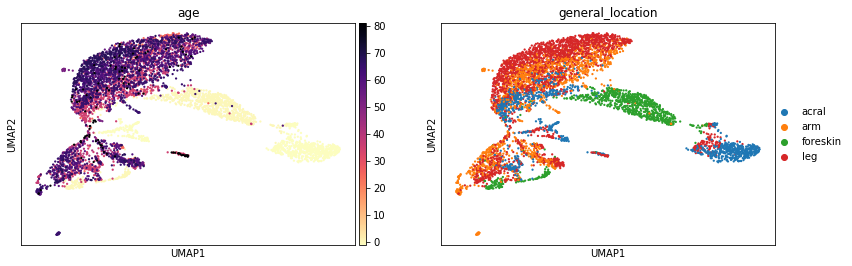

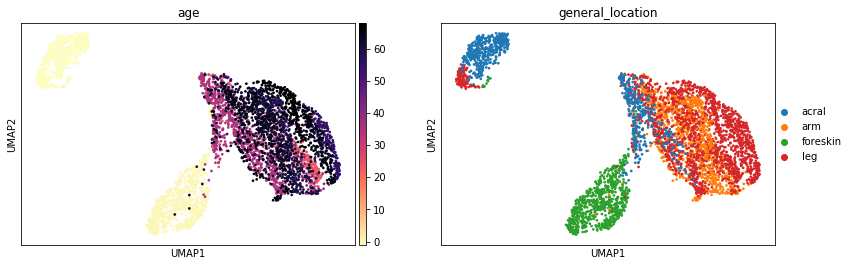

In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


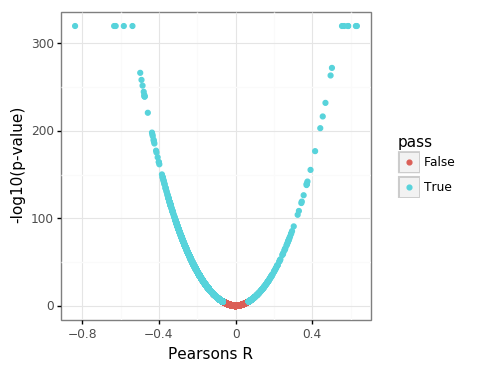

<ggplot: (-9223363244776579012)>
          gene         R           pval        R2  neglog10_pval
8121  SERPINF1 -0.837793  1.475774e-320  0.701898      319.83098
1297     CCND1 -0.634014  1.475774e-320  0.401973      319.83098
1768    CRABP1  0.632616  1.475774e-320  0.400203      319.83098
1624       CLU  0.627338  1.475774e-320  0.393553      319.83098
3760    IGFBP3 -0.625875  1.475774e-320  0.391719      319.83098
querying 1-5...done.
Finished.
0: SERPINF1
This gene encodes a member of the serpin family that does not display the serine protease inhibitory activity shown by many of the other serpin proteins. The encoded protein is secreted and strongly inhibits angiogenesis. In addition, this protein is a neurotrophic factor involved in neuronal differentiation in retinoblastoma cells. Mutations in this gene were found in individuals with osteogenesis imperfecta, type VI. [provided by RefSeq, Aug 2016].
1: CCND1
The protein encoded by this gene belongs to the highly conserved cycli

In [3]:
###############################################
###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 5

# Specify whether to use all samples or only adult samples in correlation
adults_only = False

###############################################

ref = 'age'
input_adata = adata_subset2
if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = pearsonr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'R':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df['R2'] = out_df['R']**2 
out_df = out_df.sort_values('R2', ascending=False)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
out_df['neglog10_pval'] = -np.log10(out_df['pval'])
out_df['pass'] = out_df.neglog10_pval > -np.log10(0.05/len(df))

# plot R vs p-value
plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('R','neglog10_pval', color = 'pass'))
          +labs(x='Pearsons R', y='-log10(p-value)'))

# print correlation scores table
print(out_df.drop('pass', axis = 1).head(topn))

# search correlation df
gene = out_df.gene[:topn]
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

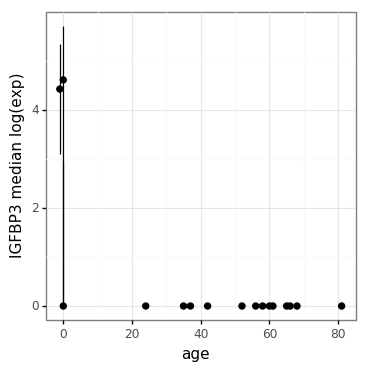

<ggplot: (8792077489882)>


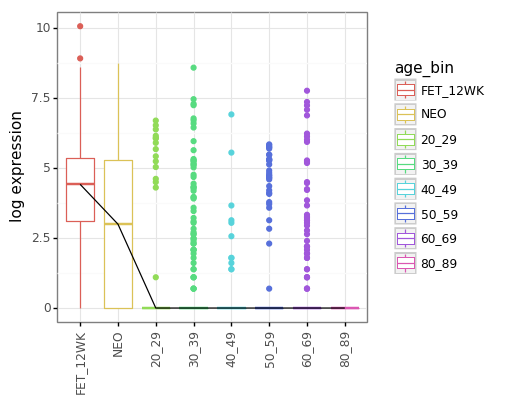

<ggplot: (8792077419461)>


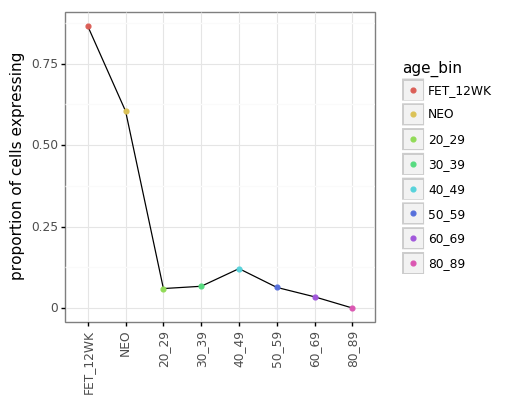

<ggplot: (8792077359350)>


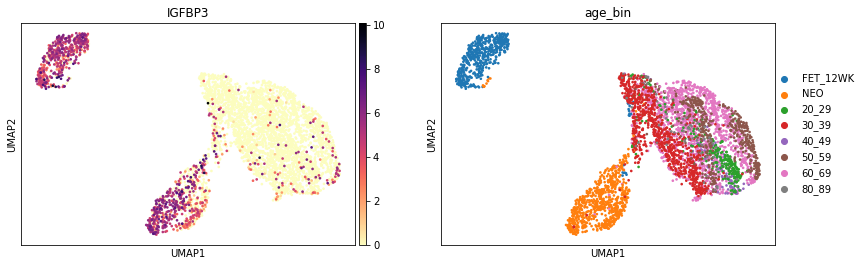

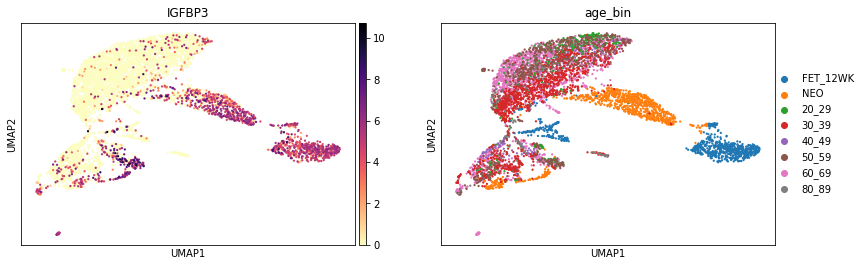

querying 1-1...done.
Finished.
0:  IGFBP3 
 This gene is a member of the insulin-like growth factor binding protein (IGFBP) family and encodes a protein with an IGFBP domain and a thyroglobulin type-I domain. The protein forms a ternary complex with insulin-like growth factor acid-labile subunit (IGFALS) and either insulin-like growth factor (IGF) I or II. In this form, it circulates in the plasma, prolonging the half-life of IGFs and altering their interaction with cell surface receptors. Alternate transcriptional splice variants, encoding different isoforms, have been characterized. [provided by RefSeq, Jul 2008].


In [4]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'IGFBP3'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_bin'

###############################################

# true age
true_age_exp(gene, input_adata)

# binned age
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]
